# Toy data example for application of artifact segmentation pipeline to automate cleaning of imaging datasets

This notebook assumes you are either making use of the pre-trained models using the provided weights, or have trained/re-trained the models on your own dataset using the tutorial notebooks (ResNet50_Artifact_Classifier.ipynb, Score-CAM.ipynb, Artifact_Segmentation_UNET.ipynb) and have your own weights files to use.

In [6]:
import os
import numpy as np
import shutil
import cv2
import matplotlib
import matplotlib.pyplot as plt

## Resizing data

For the example application here, the original images are 1080x1080 but were resized down to 576x576 for training and prediction with the artifact classifier, Score-CAM and artifact segmentation model to reduce the computational load. As such there are resizing steps when producing the segmentation masks for masking of the original high-resolution data which can be removed if not required.

In [7]:
width = 576
height = 576

In [2]:
from utils.resnet import data_resize

load_dir = 'D:/Chapter 5/Re-run/toy_dataset/images/'
save_dir = 'D:/Chapter 5/Re-run/toy_dataset/images_576/'

data_resize(width,height,load_dir=load_dir,save_dir=save_dir,ftype='.tiff')

## Use trained artifact classifier to identify images in need of artifact masking

In [8]:
from utils.resnet import DataGenerator_Pred,build_ResNet

In [9]:
# Directory of images to be classified
data_dir = 'D:/Chapter 5/Re-run/toy_dataset/images_576/'

params = {'dim': (width,height), #dimensions of image data to be classified
          'batch_size': 1,
          'n_channels': 3, #for grayscale images, the single channel is copied to create a 3-channel image to suit the ResNet50 architecture.
          'shuffle': False,
          'PATH':data_dir}

# Load in data
images=np.array(os.listdir(data_dir))
partition={'data':images}
data_generator = DataGenerator_Pred(partition['data'], **params)

In [10]:
classifier_weights = 'resnet_weight_576_16bit_081123-test_tiff_utilsdebug' #name of weights file

# Build model for prediction
classifier_model = build_ResNet()
classifier_model.load_weights(f'./weights/{classifier_weights}.h5') 

# Classify loaded data
pred = classifier_model.predict(data_generator)
pred_bool = (pred>0.5).astype('int32')

30/30 [==============================] - 2s 14ms/step


In [11]:
artifacts = []
clean = []

for im, pred_class in zip(images, pred_bool):
    if pred_class[1] == 1:
        artifacts.append(im)
    else:
        clean.append(im)

print(len(clean),len(artifacts))

1 29


## Use trained artifact segmentation model to generate masks for images

In [12]:
from utils.unet import DataGenerator_Pred, configuration, init_model

C:\Users\uqewats6\Miniconda3\envs\FiltModel\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
# Parameters
params = {'dim': (width,height),
          'batch_size': 1,
          'n_classes': 1,
          'n_channels': 1,
          'shuffle': False,
           'PATH':data_dir}

# Load in data
partition={'artifact_data': artifacts, 'clean_data': clean} 
artifact_generator = DataGenerator_Pred(partition['artifact_data'], **params)
clean_generator = DataGenerator_Pred(partition['clean_data'], **params)

In [14]:
segmentation_weights = 'U-Net_131123_test_2'

segmentation_model = init_model()
segmentation_model.load_weights(f'./weights/{segmentation_weights}.h5')

mask_dir = 'D:/Chapter 5/Re-run/toy_dataset/UNET_masks/'

### Generate segementation masks for images classified as containing artifacts

In [16]:
for i, name in enumerate(artifacts):
    predicted_mask = segmentation_model.predict(artifact_generator[i])
    mask = np.uint8(predicted_mask[0]>0.5) 
    mask_resized = cv2.resize(mask, (1080,1080))   #This resize is only necessary if original data was resized for training/classifying images as artifact containing.
    cv2.imwrite(os.path.join(mask_dir, name.split(f'_{width}')[0]+'.tiff'), mask_resized)

1/1 [==============================] - 0s 19ms/step


### Generate empty masks for images classified as clean

In [17]:
for i, name in enumerate(clean):
    mask = np.full((1080,1080), 0) #change dims to correspond to original data size.
    mask = np.uint8(mask) 
    cv2.imwrite(os.path.join(mask_dir, name.split(f'_{width}')[0]+'.tiff'), mask)

## Load in original resolution (1080x1080px) data

In [46]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pywt
import os

from skimage import (
    data, restoration, util
)

In [2]:
image_dir = 'D:/Chapter 5/Re-run/toy_dataset/images/'
mask_dir = 'D:/Chapter 5/Re-run/toy_dataset/UNET_masks/'
masked_dir = 'D:/Chapter 5/Re-run/toy_dataset/images_576_masked/'

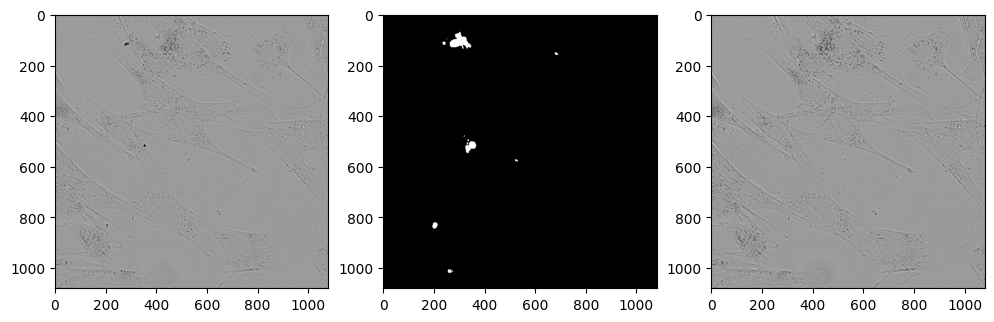

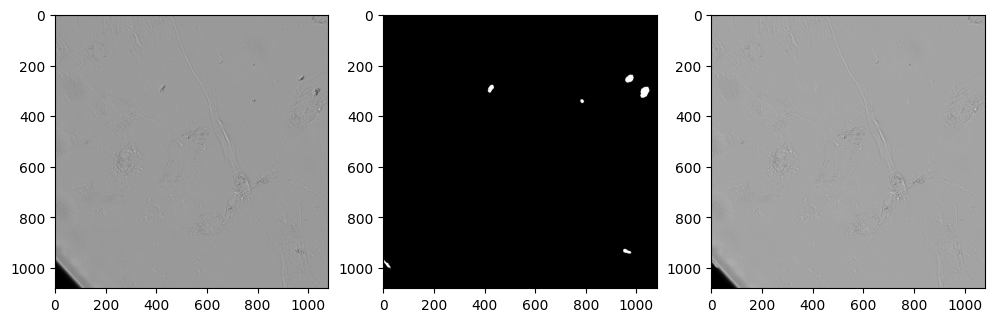

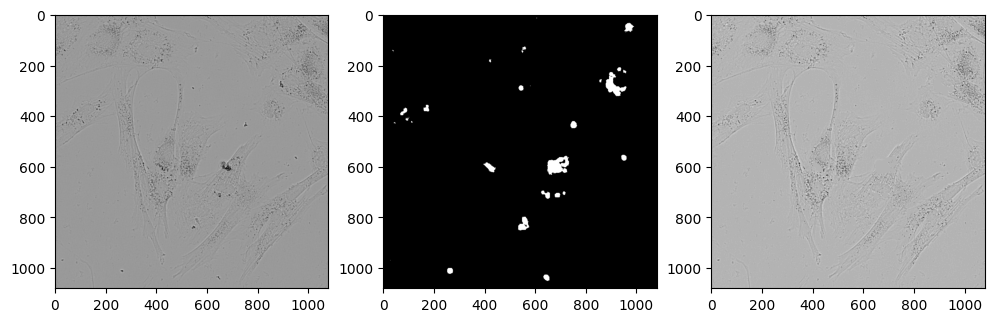

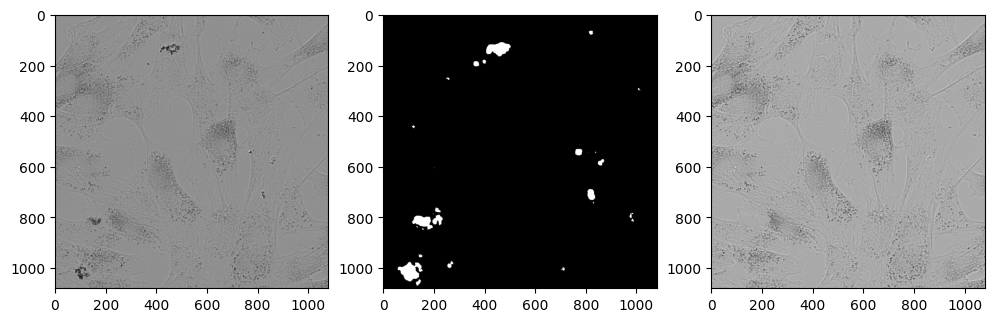

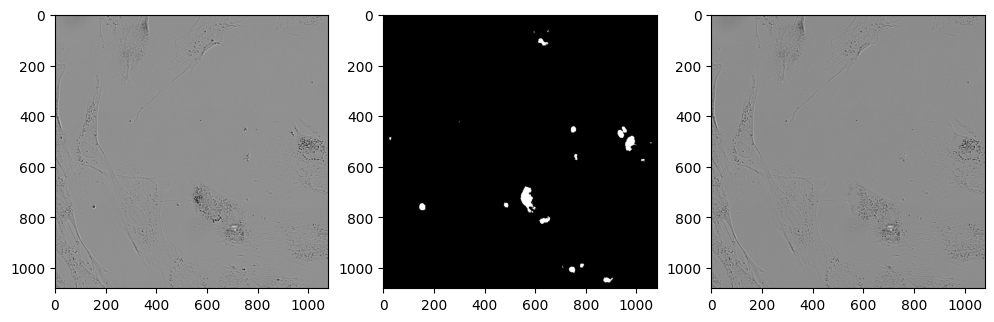

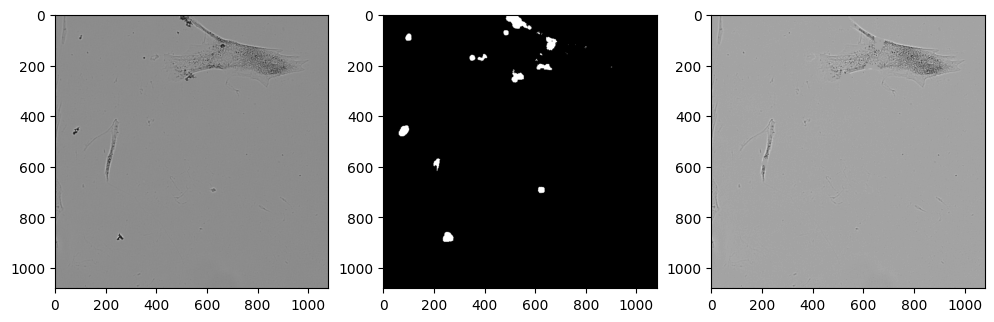

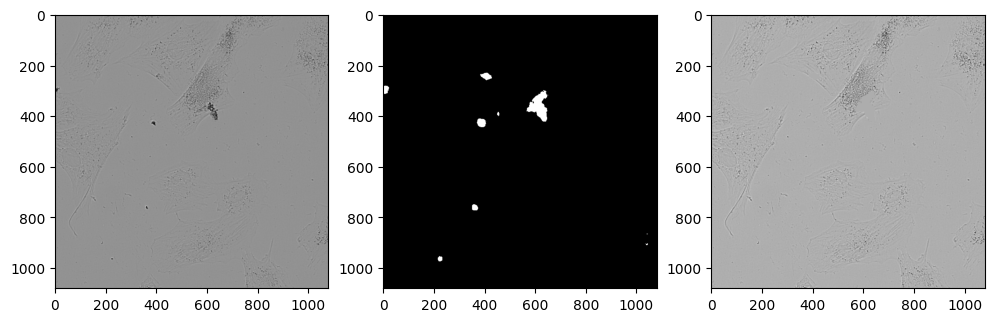

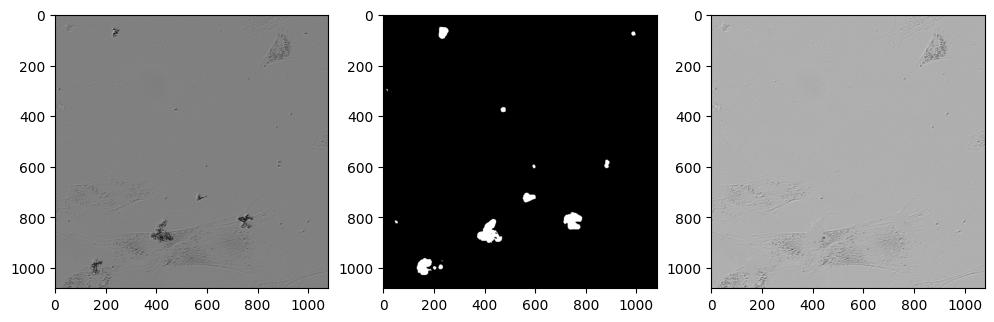

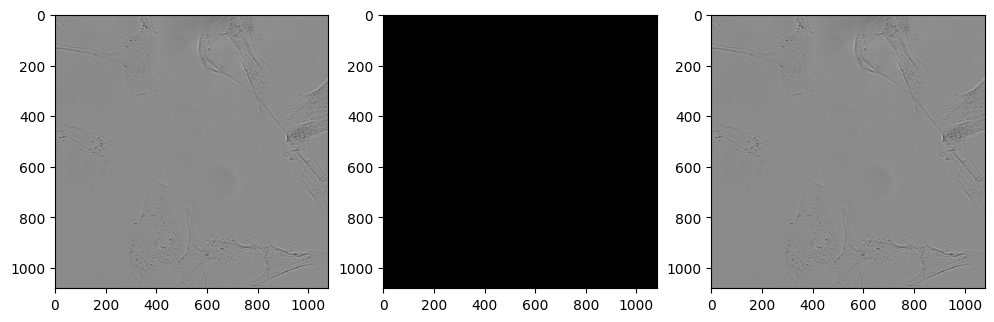

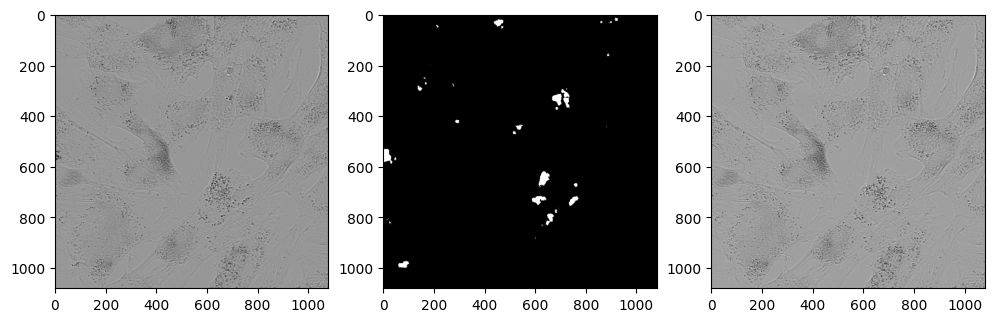

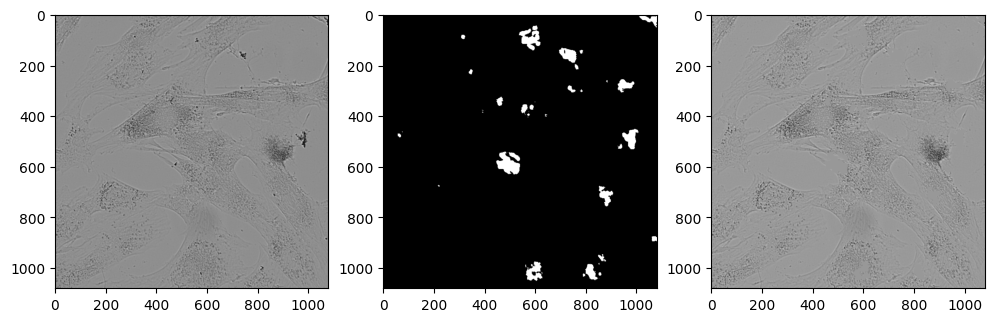

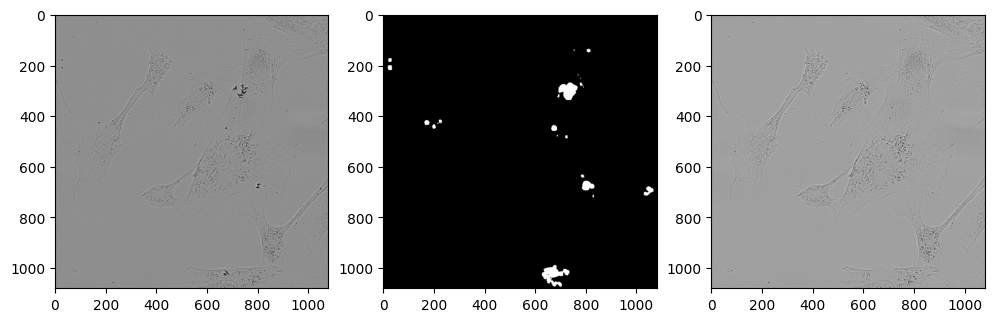

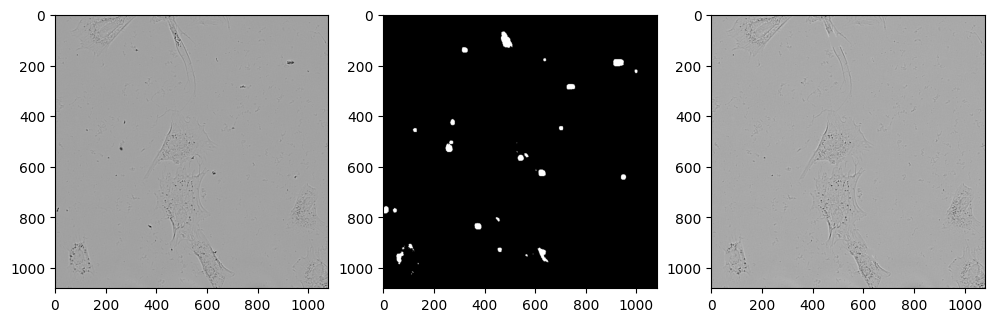

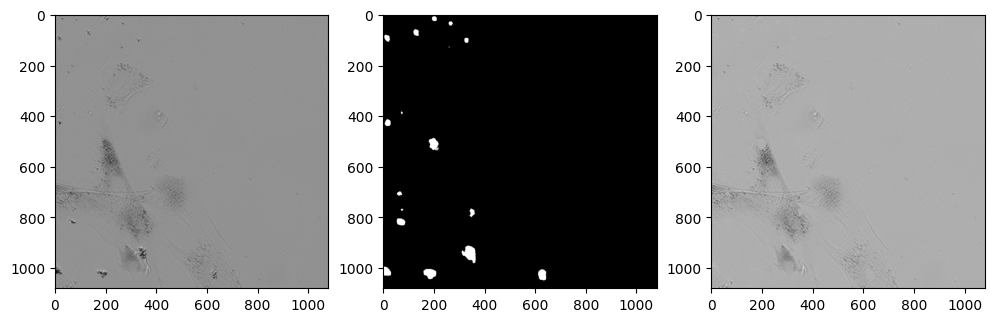

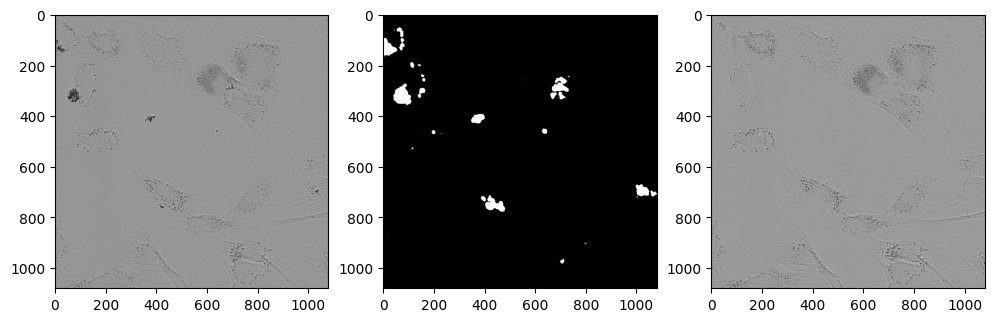

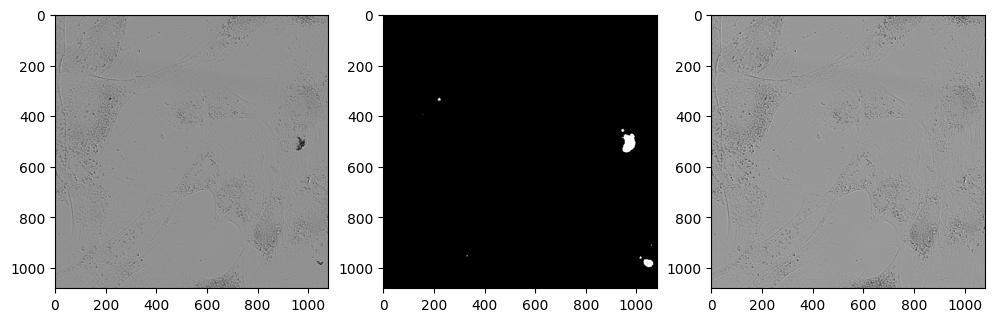

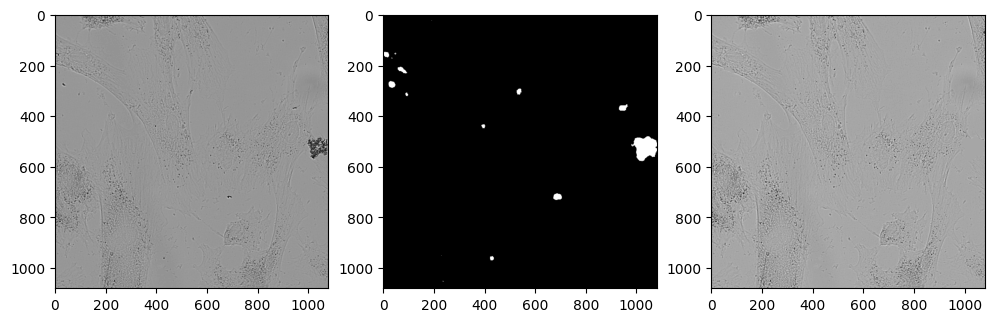

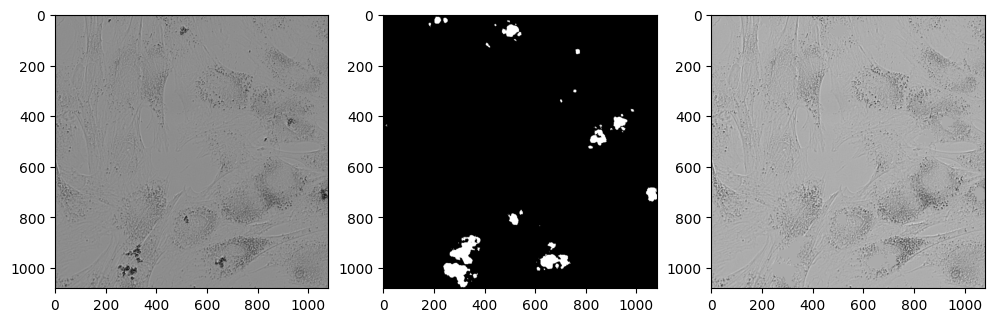

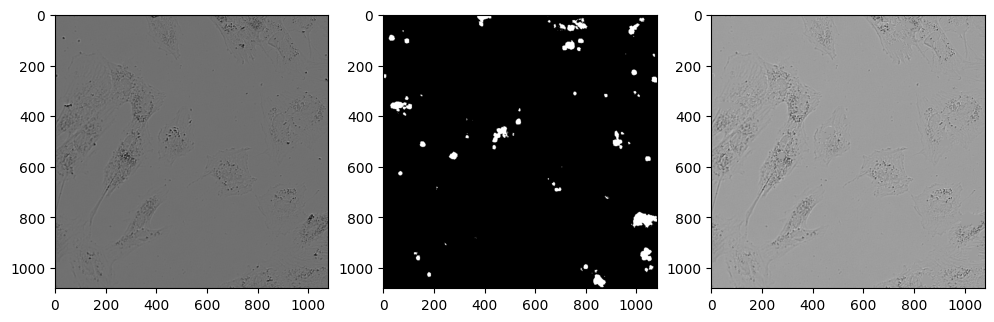

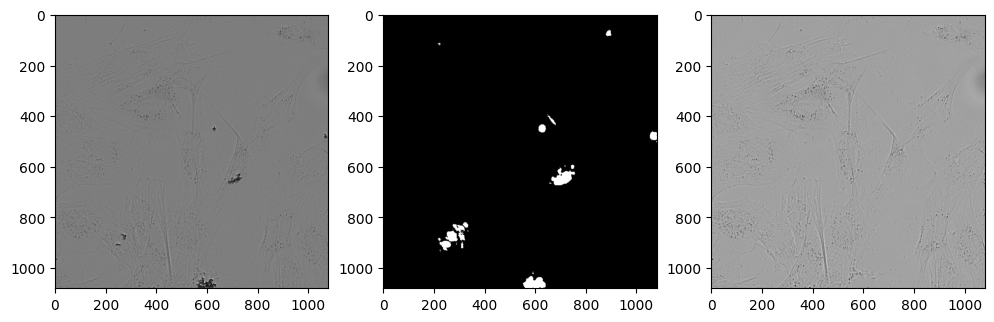

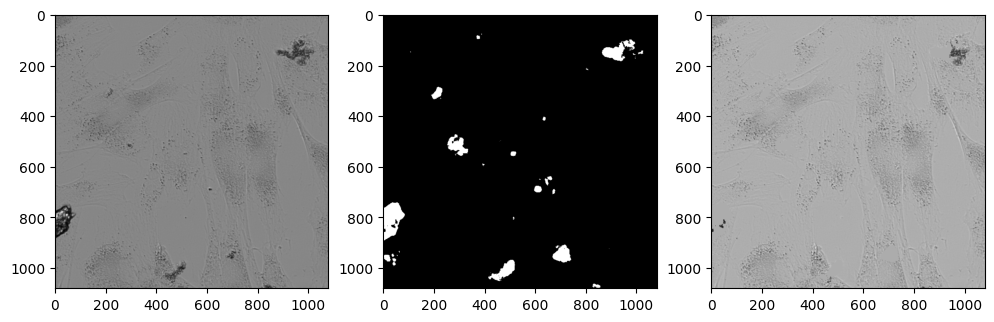

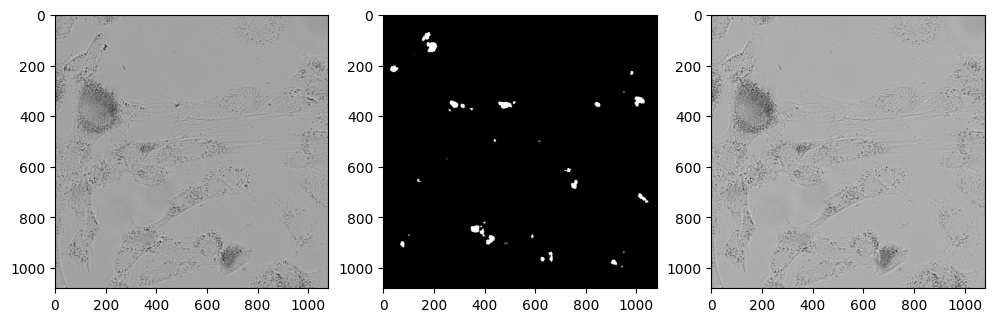

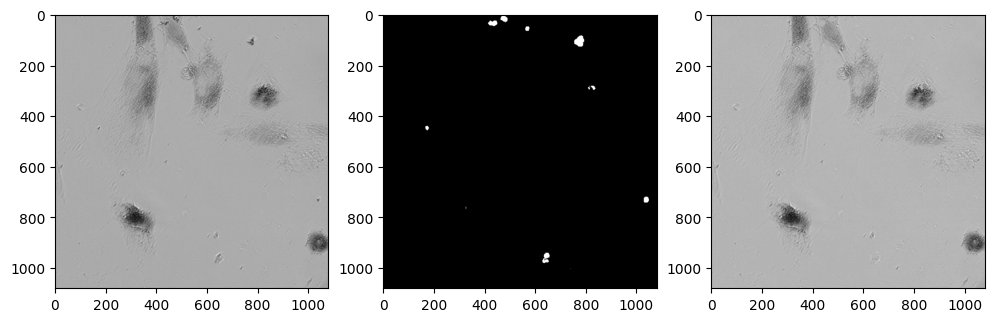

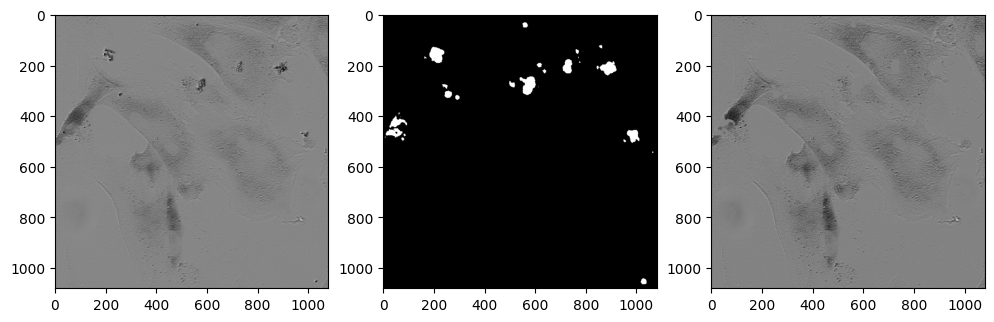

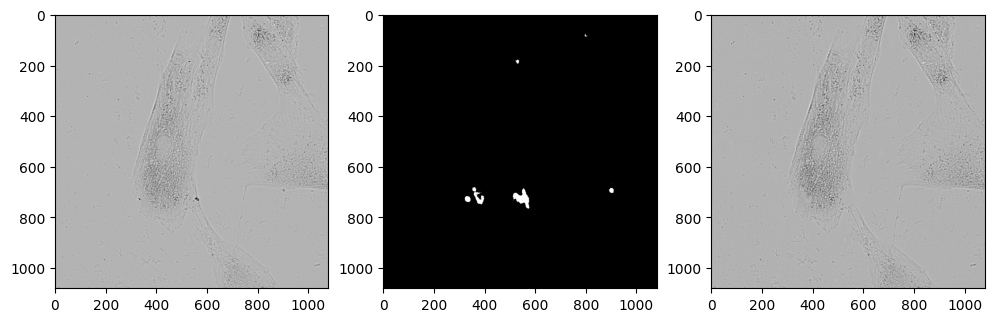

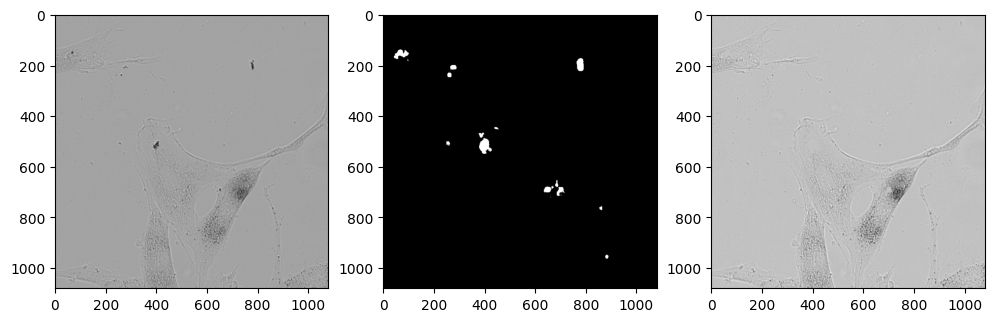

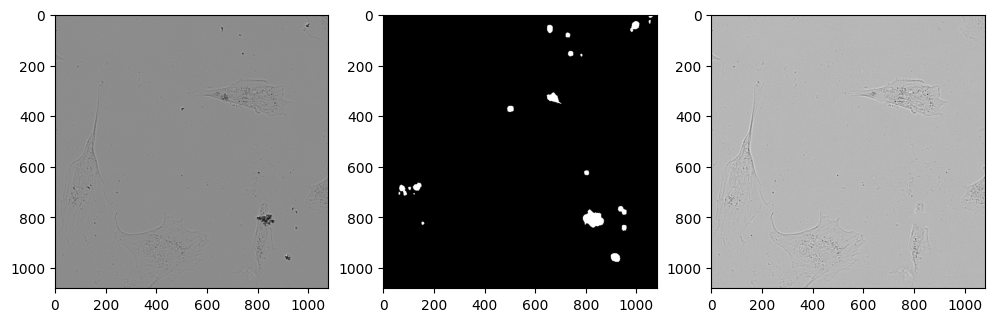

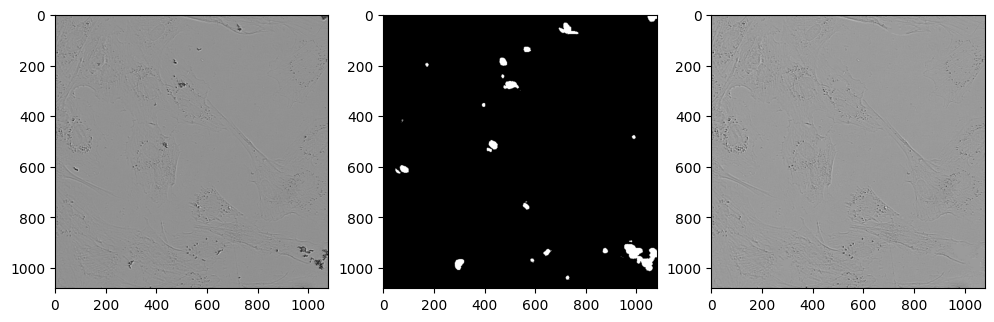

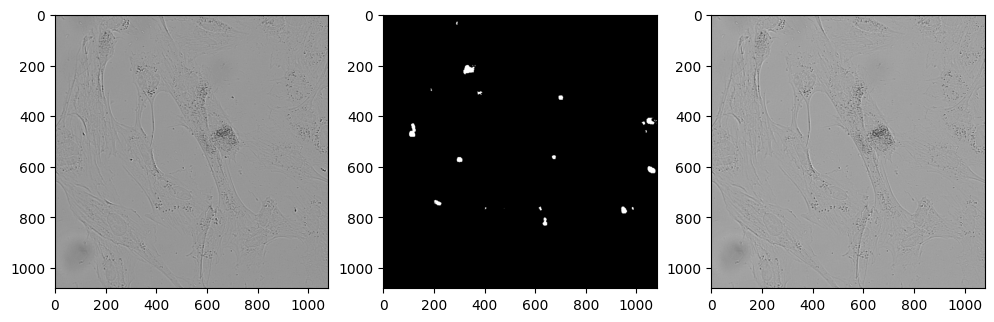

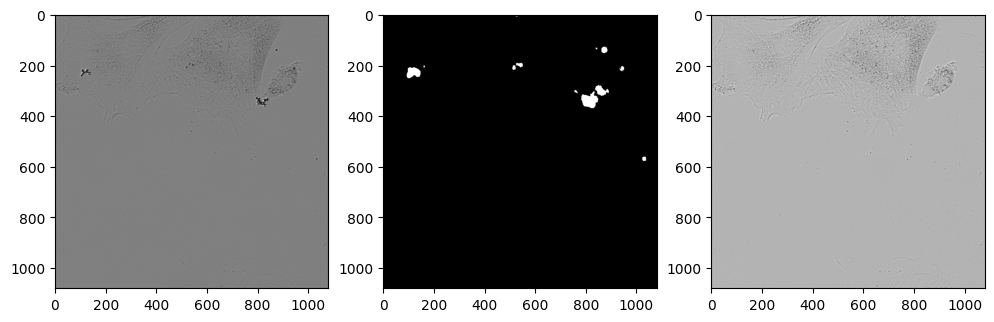

In [28]:
for image in os.listdir(image_dir):
    im = cv2.imread(os.path.join(image_dir,image),-1)
    im = np.uint8(im/256)
    im_c = im.copy()
    
    mask = cv2.imread(os.path.join(mask_dir, image),-1)
    mask = mask>0
    
    im[mask] = np.median(im)
    cv2.imwrite(os.path.join(masked_dir,image.split('.')[0]+'_masked.tiff'), im)
    
    _, axs = plt.subplots(1, 3, figsize=(12, 12))
    axs = axs.flatten()
    for img, ax in zip([im_c, mask, im], axs):
        ax.imshow(img, cmap='gray')
    plt.show()